# File Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.ensemble import GradientBoostingRegressor,GradientBoostingClassifier,RandomForestRegressor,RandomForestClassifier,VotingRegressor,VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
pd.options.mode.chained_assignment = None
from sklearn.decomposition import PCA
import datetime
from sklearn.neural_network import MLPClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from matplotlib.lines import Line2D

# Load data

In [159]:
df_processed_data = pd.read_csv('shannon_data_residential 2.csv')
df_original = df_processed_data.copy()


In [160]:
df_processed_data.columns = [x.strip('.x') for x in list(df_processed_data)]
df_processed_data['date'] = [x.split(' ')[0] for x in df_processed_data['Date_Time']]
df_processed_data['time'] = [x.split(' ')[1] for x in df_processed_data['Date_Time']]

df_processed_data['date_count'] = [(datetime.datetime(int(x.split('/')[2]),int(x.split('/')[1]),int(x.split('/')[0]))-datetime.datetime(2003,1,1)).days for x in df_processed_data.date]
df_processed_data['minutes'] = [int(x.split(':')[0])*60+int(x.split(':')[1]) for x in df_processed_data['time']]

df_processed_data.drop(['Date_Time','date','time'],axis=1,inplace=True)

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0., 56510.,
         3548.,  3567.,  2694.,  1384.,  7771.,     0.,     0.,     0.,
            0.]),
 array([ 0,  2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32,
        34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66,
        68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98]),
 <BarContainer object of 49 artists>)

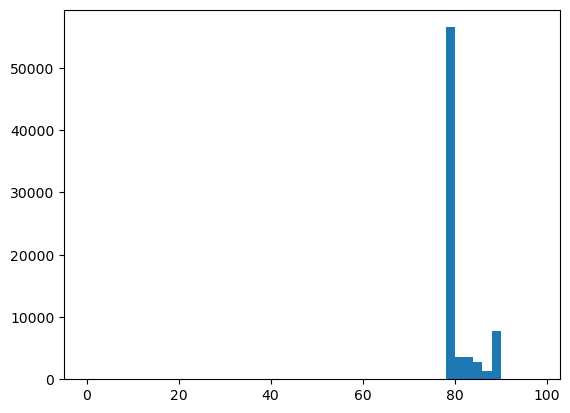

In [161]:
plt.hist(df_processed_data['Percent_Not_Saved'],bins=np.arange(0,100,2))

In [162]:
# df_processed_data['minutes'] = [dates_dict['minutes'][x] for x in df_processed_data['OID_']]
# df_processed_data['date_count'] = [dates_dict['date_count'][x] for x in df_processed_data['OID_']]

In [163]:
# list(pd.read_csv('shannon_data_residential 1.csv'))

In [164]:
# list(pd.read_csv('shannon_data_residential.csv'))

# Combining Some variables

In [165]:
def combine_cols(df,label):
    dfc = df.copy()
    cols = [x for x in df_numeric if label in x]
    most_likely = dfc[cols].idxmax(axis=1)
    most_likely = [x.strip(label) for x in most_likely]
    most_likely = [x.replace('P','') for x in most_likely]
    most_likely = [x.replace('plus','') for x in most_likely]
    most_likely = [float(x) for x in most_likely]
    dfc[f'most_likely_{label}'] = most_likely
    dfc.drop(cols,axis=1,inplace=True)
    return(dfc)

# Additional Preprocessing

In [166]:
# Split categorical and numeric variables
numeric_vars = [x for x in list(df_processed_data) if type(df_processed_data.loc[0,x])!=type('str')]
categorical_vars = [x for x in list(df_processed_data) if (type(df_processed_data.loc[0,x])==type('str'))&('Date_Time' not in x)]

# convert categorical variables to one-hot-encoded variables (binary)
df_one_hot_encoded = pd.get_dummies(df_processed_data[categorical_vars])

# get just numeric variables
df_numeric = df_processed_data[numeric_vars]
df_numeric = df_numeric.astype(float)

# Add back the one-hot-encoded categorical variables
df_numeric = df_numeric.join(df_one_hot_encoded)

# First, remove columns which have a significant portion of NAs (we're saying more than 1000
na_count = df_numeric.isna().sum().sort_values(ascending=True)
df_numeric = df_numeric[[x for x in list(df_numeric) if x not in list(na_count[na_count>11000].index)]]
# Now for all the remaining nans, remove the rows
df_numeric = df_numeric.dropna()

In [167]:
df_missing_GNS = df_processed_data[df_processed_data[[x for x in list(na_count[na_count>1].index)]]['GNS_Rep_Cost'].isna()]

In [168]:
df_missing_GNS.to_csv('missing_gns_values.csv')

In [169]:
np.sum(df_missing_GNS[[x for x in list(df_missing_GNS) if 'GNS' in x]].isna())

GNS_Age                    10253
GNS_Storeys                10253
GNS_Floor_Area             10253
GNS_Site_Cover             10253
GNS_Floor_Hgt              10253
GNS_Rep_Cost               10253
GNS_Num_Units              10253
GNS_Neighb_Dist                0
GNS_Use_Category            3056
GNS_Construction_Type_1     3056
GNS_Roof_Const             10253
GNS_Wall_Const             10253
GNS_Roof_Pitch             10253
GNS_Parapet                10253
dtype: int64

In [170]:
df_numeric = combine_cols(df_numeric,'Rooms.')
df_numeric = combine_cols(df_numeric,'Beds.')
df_numeric = combine_cols(df_numeric,'noVehc.')
df_numeric = combine_cols(df_numeric,'children.')

label = 'yrs_at_res.'
df_numeric.rename(columns={'yrs_at_res.30more':'yrs_at_res.30'},inplace=True) 
cols = [x for x in df_numeric if label in x]
most_likely = df_numeric[cols].idxmax(axis=1)
most_likely = [x.strip(label) for x in most_likely]
most_likely = [np.mean([float(y) for y in x.split('_')]) for x in most_likely]
df_numeric[f'most_likely_{label}'] = most_likely
df_numeric.drop(cols,axis=1,inplace=True)

label = 'income.'
df_numeric.rename(columns={'income.less5K':'income.5K',},inplace=True) 
cols = [x for x in df_numeric if (label in x)&('K' in x)]
most_likely = df_numeric[cols].idxmax(axis=1)
most_likely = [x.strip(label) for x in most_likely]
most_likely = [x.replace('K','').replace('P','') for x in most_likely]
most_likely = [np.mean([float(y) for y in x.split('_')]) for x in most_likely]
df_numeric[f'most_likely_{label}'] = most_likely
df_numeric.drop(cols,axis=1,inplace=True)

label = 'hrsEmploy.'
df_numeric.rename(columns={'hrsEmploy.60more':'hrsEmploy.60'},inplace=True) 
cols = [x for x in df_numeric if (label in x)]
most_likely = df_numeric[cols].idxmax(axis=1)
most_likely = [x.strip(label) for x in most_likely]
most_likely = [np.mean([float(y) for y in x.split('_')]) for x in most_likely]
df_numeric[f'most_likely_{label}'] = most_likely
df_numeric.drop(cols,axis=1,inplace=True)

df_numeric['earning_not_from_work'] = df_numeric['income.ACC']+df_numeric['income.supported']+df_numeric['income.jobSeeker']+df_numeric['income.soleParent']+df_numeric['income.otherBen']
df_numeric['combined_not_working'] = df_numeric['employed.notInLF']+df_numeric['employed.Unemployed']
df_numeric['earning_from_work'] = df_numeric['income.salary']+df_numeric['income.selfEmp']
df_numeric['studying'] = df_numeric['study.fullTime']+df_numeric['study.partTime']
df_numeric['diffCom.atleastSome'] = df_numeric['diffCom.some']+df_numeric['diffCom.aLot']+df_numeric['diffCom.cannot']
df_numeric['diffWalk.atleastSome'] = df_numeric['diffWalk.some']+df_numeric['diffWalk.aLot']+df_numeric['diffWalk.cannot']
df_numeric['homeOwn.OwnOrTrust'] = df_numeric['homeOwn.trust']+df_numeric['homeOwn.own']

cols = [x for x in list(df_numeric) if 'damp' in x]
numeric_damp = []
for row in df_numeric[cols].idxmax(axis=1):
    if row=='damp.no':
        numeric_damp.append(0)
    elif row=='damp.sometimes':
        numeric_damp.append(1)
    elif row=='damp.always':
        numeric_damp.append(2)
    else:
        asdf
df_numeric['dampness'] = numeric_damp

heat_source_cols = [x for x in df_numeric if "Heat_Source" in x]
fire_source_cols = [x for x in df_numeric if "Fire_Cause" in x]
mould_cols = [x for x in df_numeric if 'mould' in x]
fuel_cols = [x for x in df_numeric if 'fuel' in x]
smoking_cols = [x for x in df_numeric if ('smoking' in x)&('regular' not in x)]
dwelling_cols = [x for x in df_numeric if 'dwelling' in x]
prev_residence_cols = [x for x in list(df_numeric) if ('res_5yrs_prev' in x)&('same' not in x)]
employed_cols = [x for x in list(df_numeric) if ('employed' in x)]
income_cols =  ['income.ACC','income.supported','income.jobSeeker','income.soleParent','income.otherBen','income.salary','income.selfEmp']
damp_cols =  ['damp.no','damp.sometimes','damp.always']
gns_use = [x for x in list(df_numeric) if 'GNS_Use_Category' in x]

others_to_remove = ['OID_','MB2020_V2_','SA12018_V1','occupied','ResAway','nonPartnered','born.overseas','study.fullTime','study.partTime',
                     'HSCert','HSDip','homeOwn.trust','homeOwn.own','diffCom.some','diffCom.aLot','diffCom.cannot','diffWalk.some','diffWalk.aLot','diffWalk.cannot',
                    'age.30_64','age.15_29']

temp_remove = ['Percent_Not_Saved','Damage_m2']

removal_list = heat_source_cols+fire_source_cols+mould_cols+fuel_cols+smoking_cols+dwelling_cols+prev_residence_cols+employed_cols+income_cols+others_to_remove+damp_cols+gns_use+temp_remove

df_numeric.drop(removal_list,axis=1,inplace=True)

In [171]:
# percentage over 70,000 for income
# just look at approx even split 
# age, just look at higher and lower bands.. may need to addtogether 15 and 65 approx.

**Now drop the variables which you won't have in a predictive model** 

This makes a massive difference. If you just put in all the variables, you will get a really good model for casualties.
But the problem is that fatality and injury count are after the fact. I gather we want a predictive model.. or includes levers like arrival time 

In [16]:
df_numeric = df_numeric[[x for x in list(df_numeric) if x not in ['Injury_Count','Fatality_Count']]]

In [17]:
# also need to drop variables which are always zero
df_numeric = df_numeric[[x for x in list(df_numeric) if x not in ['GNS_Use_Category_Appurtenant','GNS_Use_Category_Forestry, Mining','GNS_Roof_Const_Roughcast,etc']]]

In [18]:
target_variable = 'Casualty_Count'
independent_variables = [x for x in list(df_numeric) if x!=target_variable]

# split into testing and training
df_training = df_numeric.sample(int(len(df_numeric)*0.8))
df_testing = df_numeric[~df_numeric.index.isin(df_training.index)]

# Normalise the data
training_mins = np.min(df_training[independent_variables])
training_maxes = np.max(df_training[independent_variables])

df_training.loc[:,independent_variables] = (df_training[independent_variables]-training_mins)/(training_maxes-training_mins)
df_testing.loc[:,independent_variables] = (df_testing[independent_variables]-training_mins)/(training_maxes-training_mins)

# Adding extra rows which have casualties so that the dataset is approximately equal
df_training_0 = df_training[df_training[target_variable]==0]
df_training_gt0 = df_training[df_training[target_variable]>0]
df_training = df_training_0.append(pd.concat([df_training_gt0]*int(1+len(df_training_0)/len(df_training_gt0))))


In [19]:
# # Just to make it faster
# df_training = df_training.sample(50000)

# Regression Model Training and predictions

In [20]:
# # Train the model
# rf = RandomForestRegressor()
# rf.fit(df_training[independent_variables],df_training[target_variable])

In [21]:
# predictions = rf.predict(df_testing[independent_variables])

In [22]:
# df_testing.loc[:,'Casualty_Count_predicted'] = predictions
# df_testing.loc[:,'error'] = df_testing['Casualty_Count']-df_testing['Casualty_Count_predicted']

## Regression Results Analysis

In [23]:
# plt.hist(df_testing['Casualty_Count'])
# plt.hist(df_testing['Casualty_Count_predicted'])
# plt.title('histogram of actual casualties (blue) and casualties predicted (orange)')

In [24]:
# plt.hist(df_testing['error'])
# plt.title('histogram of the difference between actual casualties and casualties predicted')

In [25]:
# np.max(df_testing.error)

In [26]:
# np.min(df_testing.error)

In [27]:
# np.mean(df_testing.error**2)

In [28]:
# np.median(df_testing.error**2)

In [29]:
# df_testing.loc[:,'Casualty_Count_predicted_int'] = [int(x) for x in df_testing['Casualty_Count_predicted']]
# df_testing.loc[:,'error_int'] = df_testing['Casualty_Count']-[int(x) for x in df_testing['Casualty_Count_predicted_int']]


In [30]:
# actual_vs_predicted_casuality_dict = {}
# for casualty_count,group in df_testing.groupby('Casualty_Count'):
#     actual_vs_predicted_casuality_dict.update({
#         casualty_count:{k:len(v) for k,v in group.groupby('Casualty_Count_predicted_int')}
#     })
    

In [31]:
# group['Casualty_Count_predicted_int']

In [32]:
# df_result_summary = pd.DataFrame.from_dict(actual_vs_predicted_casuality_dict,orient='index').fillna(0)
# print('compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count')
# df_result_summary

In [33]:
# df_feature_importance = pd.DataFrame.from_dict({x:y for x,y in zip(list(independent_variables),rf.feature_importances_)},orient='index')
# df_feature_importance.rename(columns={0:'importance'},inplace=True)
# df_feature_importance.sort_values('importance',ascending=False,inplace=True)
# df_feature_importance

# Classifier testing

In [34]:
df_testing.loc[:,target_variable] = [0 if x<1 else 1 for x in df_testing[target_variable]]
df_training.loc[:,target_variable] = [0 if x<1 else 1 for x in df_training[target_variable]]

In [35]:
# Train the model
def model_test(rf,independent_variables):
    # rf = GradientBoostingClassifier()
    rf.fit(df_training[independent_variables],df_training[target_variable])

    predictions = rf.predict(df_testing[independent_variables])

    df_testing.loc[:,'Casualty_Count_predicted'] = predictions
    df_testing.loc[:,'error'] = df_testing['Casualty_Count']-df_testing['Casualty_Count_predicted']

    actual_vs_predicted_casuality_dict = {}
    for casualty_count,group in df_testing.groupby('Casualty_Count'):
        actual_vs_predicted_casuality_dict.update({
            casualty_count:{k:len(v) for k,v in group.groupby('Casualty_Count_predicted')}
        })

    df_result_summary = pd.DataFrame.from_dict(actual_vs_predicted_casuality_dict,orient='index').fillna(0)
    
    tp = df_result_summary.loc[1,1]
    tn = df_result_summary.loc[0,0]
    fn = df_result_summary.loc[1,0]
    fp = df_result_summary.loc[0,1]

    fscore = 2*tp/(2*tp+fp+fn)

    print('F-score',fscore)
    print('')
    
    print('compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count')
    return(df_result_summary,rf)

In [36]:
model_test(DecisionTreeClassifier(),independent_variables)

F-score 0.20029239766081872

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


(      0    1
 0  9492  569
 1   525  137,
 DecisionTreeClassifier())

In [37]:
model_test(KNeighborsClassifier(),independent_variables)

F-score 0.10909090909090909

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


(      0     1
 0  8279  1782
 1   521   141,
 KNeighborsClassifier())

In [38]:
model_test(GaussianNB(),independent_variables)

F-score 0.11830113014947138

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


(     0     1
 0  400  9661
 1   13   649,
 GaussianNB())

In [39]:
# this one was too slow, don't run
# model_test(GaussianProcessClassifier(),independent_variables)

In [40]:
model_test(AdaBoostClassifier(),independent_variables)

F-score 0.17164931138730266

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


(      0     1
 0  5280  4781
 1   151   511,
 AdaBoostClassifier())

In [41]:
model_test(QuadraticDiscriminantAnalysis(),independent_variables)

F-score 0.11703650680028632

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\sklearn\discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


(     0     1
 0  201  9860
 1    8   654,
 QuadraticDiscriminantAnalysis())

In [42]:
# # this was slow, but bearably so, also not very good 
# model_test(MLPClassifier(),independent_variables)

In [43]:
model_test(RandomForestClassifier(),independent_variables)

F-score 0.07319952774498228

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


(      0    1
 0  9907  154
 1   631   31,
 RandomForestClassifier())

In [44]:
model_test(GradientBoostingClassifier(),independent_variables)

F-score 0.17747777411919657

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


(      0     1
 0  5188  4873
 1   123   539,
 GradientBoostingClassifier())

In [45]:
model_test(LinearSVC(),independent_variables)

F-score 0.13902818606259726

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


(      0     1
 0  5342  4719
 1   260   402,
 LinearSVC())

In [46]:
model_test(LogisticRegression(),independent_variables)

F-score 0.1352971399212194

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


(      0     1
 0  5279  4782
 1   267   395,
 LogisticRegression())

Test a Multi-layer Perceptron

In [47]:
model_test(MLPClassifier(),independent_variables)

F-score 0.11235059760956176

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(      0     1
 0  8354  1707
 1   521   141,
 MLPClassifier())

In [48]:
model_test(MLPClassifier(activation='logistic'),independent_variables)

F-score 0.13333333333333333

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(      0     1
 0  7307  2754
 1   418   244,
 MLPClassifier(activation='logistic'))

In [49]:
model_test(MLPClassifier(hidden_layer_sizes=20),independent_variables)

F-score 0.1222169587873046

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


(      0     1
 0  6759  3302
 1   404   258,
 MLPClassifier(hidden_layer_sizes=20))

**My top three algorithms:**
 - GradientBoostingClassifier
 - AdaBoostClassifier
 - KNeighborsClassifier

# VotingClassifier

Use a comination of algorithms (they 'vote' for the best solution). This can smooth out quirks in the results and sometimes improve results

In [50]:
vc = VotingClassifier([('gb',GradientBoostingClassifier()),
                       ('ab',AdaBoostClassifier()),
                       ('kn',DecisionTreeClassifier()),
                       ('ls',LinearSVC()),
                       ('lr',LogisticRegression()),
                      ])
model_test(vc,independent_variables)

C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\sklearn\linear_model\_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


F-score 0.18236301369863014

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


(      0     1
 0  6477  3584
 1   236   426,
 VotingClassifier(estimators=[('gb', GradientBoostingClassifier()),
                              ('ab', AdaBoostClassifier()),
                              ('kn', DecisionTreeClassifier()),
                              ('ls', LinearSVC()),
                              ('lr', LogisticRegression())]))

In [51]:
vc = VotingClassifier([('gb',GradientBoostingClassifier()),('ab',AdaBoostClassifier()),('kn',DecisionTreeClassifier())])
model_test(vc,independent_variables)

F-score 0.1796560556165386

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


(      0     1
 0  5748  4313
 1   171   491,
 VotingClassifier(estimators=[('gb', GradientBoostingClassifier()),
                              ('ab', AdaBoostClassifier()),
                              ('kn', DecisionTreeClassifier())]))

In [52]:
vc = VotingClassifier([('gb',GradientBoostingClassifier()),('ab',AdaBoostClassifier())])
model_test(vc,independent_variables)

F-score 0.17935388043074638

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


(      0     1
 0  5820  4241
 1   179   483,
 VotingClassifier(estimators=[('gb', GradientBoostingClassifier()),
                              ('ab', AdaBoostClassifier())]))

In [53]:
vc = VotingClassifier([('dt',DecisionTreeClassifier()),('ab',AdaBoostClassifier())])
model_test(vc,independent_variables)

F-score 0.19150707743547044

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


(      0    1
 0  9637  424
 1   547  115,
 VotingClassifier(estimators=[('dt', DecisionTreeClassifier()),
                              ('ab', AdaBoostClassifier())]))

The results are not meaningfully better than individual algorithms. Default to just gradientboosting (AdaBoosting and GradientBoosting are similar algorithms anyway)

## Increase number of estimators for adaboosting

In [54]:
model_test(AdaBoostClassifier(n_estimators=500),independent_variables)

F-score 0.17482225010455876

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


(      0     1
 0  6359  3702
 1   244   418,
 AdaBoostClassifier(n_estimators=500))

Doesn't seem very sensitive to the number of estimators

# Dimensionality reduction

In [55]:
# Train the model
def pca_model_test(rf,independent_variables,train,test):
    # rf = GradientBoostingClassifier()
    rf.fit(train,df_training[target_variable])

    predictions = rf.predict(test)

    df_testing.loc[:,'Casualty_Count_predicted'] = predictions
    df_testing.loc[:,'error'] = df_testing['Casualty_Count']-df_testing['Casualty_Count_predicted']

    actual_vs_predicted_casuality_dict = {}
    for casualty_count,group in df_testing.groupby('Casualty_Count'):
        actual_vs_predicted_casuality_dict.update({
            casualty_count:{k:len(v) for k,v in group.groupby('Casualty_Count_predicted')}
        })

    df_result_summary = pd.DataFrame.from_dict(actual_vs_predicted_casuality_dict,orient='index').fillna(0)
    
    tp = df_result_summary.loc[1,1]
    tn = df_result_summary.loc[0,0]
    fn = df_result_summary.loc[1,0]
    fp = df_result_summary.loc[0,1]

    fscore = 2*tp/(2*tp+fp+fn)

    print('F-score',fscore)
    print('')
    
    print('compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count')
    return(df_result_summary,rf)

In [56]:
df_training[independent_variables].shape

(80576, 142)

In [57]:
# pca = PCA(n_components=100)
# train_transformed = pca.fit_transform(df_training[independent_variables])
# test_transformed = pca.transform(df_testing[independent_variables])

In [58]:
# pca_model_test(AdaBoostClassifier(),independent_variables,train_transformed,test_transformed)

**Doesn't seem to be more effective**

# Reducing Some feature

In [59]:
df_summary,mod = model_test(AdaBoostClassifier(),independent_variables)

F-score 0.17164931138730266

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


In [60]:
df_summary

,0,1
0,5280,4781
1,151,511


In [61]:
feat_imp_dict = {var:imp for imp,var in zip(mod.feature_importances_,independent_variables)}
{var:imp for var,imp in feat_imp_dict.items() if imp>0.01}

{'GNS_Age': 0.02,
 'GNS_Storeys': 0.02,
 'GNS_Floor_Area': 0.04,
 'GNS_Site_Cover': 0.04,
 'GNS_Rep_Cost': 0.04,
 'GNS_Num_Units': 0.02,
 'GNS_Neighb_Dist': 0.06,
 'First_Arrival_Mins': 0.06,
 'Second_Arrival_Mins': 0.06,
 'joinedDwelling': 0.02,
 'Empty': 0.02,
 'UnderConst': 0.02,
 'noHeating': 0.04,
 'electricHeater': 0.04,
 'woodBurner': 0.02,
 'coalBurner': 0.02,
 'otherHeat': 0.02,
 'homeOwn.no': 0.04,
 'diffCom.no': 0.02,
 'usual_pop_count': 0.02,
 'age.under15': 0.02,
 'res_5yrs_prev.same': 0.02,
 'language.NZsign': 0.04,
 'descent.Maori': 0.02,
 'employment.self': 0.02,
 'occupation.manager': 0.02,
 'households': 0.02,
 'date_count': 0.06,
 'minutes': 0.02,
 'earning_not_from_work': 0.02,
 'combined_not_working': 0.02,
 'studying': 0.02,
 'diffWalk.atleastSome': 0.02,
 'homeOwn.OwnOrTrust': 0.04}

In [62]:
independent_variables_over_1p = [var for var,imp in feat_imp_dict.items() if imp>0.01]
independent_variables_over_1p

['GNS_Age',
 'GNS_Storeys',
 'GNS_Floor_Area',
 'GNS_Site_Cover',
 'GNS_Rep_Cost',
 'GNS_Num_Units',
 'GNS_Neighb_Dist',
 'First_Arrival_Mins',
 'Second_Arrival_Mins',
 'joinedDwelling',
 'Empty',
 'UnderConst',
 'noHeating',
 'electricHeater',
 'woodBurner',
 'coalBurner',
 'otherHeat',
 'homeOwn.no',
 'diffCom.no',
 'usual_pop_count',
 'age.under15',
 'res_5yrs_prev.same',
 'language.NZsign',
 'descent.Maori',
 'employment.self',
 'occupation.manager',
 'households',
 'date_count',
 'minutes',
 'earning_not_from_work',
 'combined_not_working',
 'studying',
 'diffWalk.atleastSome',
 'homeOwn.OwnOrTrust']

# Test with only variables which can be used in classification

In [63]:
# Train the model
def model_test(rf,independent_variables):
    # rf = GradientBoostingClassifier()
    rf.fit(df_training[independent_variables],df_training[target_variable])

    predictions = rf.predict(df_testing[independent_variables])
    predictions_proba = rf.predict_proba(df_testing[independent_variables])
    
    df_testing.loc[:,'Casualty_Count_predicted'] = predictions
    df_testing.loc[:,'error'] = df_testing['Casualty_Count']-df_testing['Casualty_Count_predicted']

    df_testing.loc[:,'Casualty_Probability'] = predictions_proba[:,1] 
    
    actual_vs_predicted_casuality_dict = {}
    for casualty_count,group in df_testing.groupby('Casualty_Count'):
        actual_vs_predicted_casuality_dict.update({
            casualty_count:{k:len(v) for k,v in group.groupby('Casualty_Count_predicted')}
        })

    df_result_summary = pd.DataFrame.from_dict(actual_vs_predicted_casuality_dict,orient='index').fillna(0)
    
    tp = df_result_summary.loc[1,1]
    tn = df_result_summary.loc[0,0]
    fn = df_result_summary.loc[1,0]
    fp = df_result_summary.loc[0,1]

    fscore = 2*tp/(2*tp+fp+fn)

    print('F-score',fscore)
    print('')
    
    print('compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count')
    return(df_result_summary,rf)

In [64]:
not_for_prediction_list = ['First_Arrival_Mins','Second_Arrival_Mins','date_count','minutes']

In [65]:
prediction_list = [x for x in independent_variables if x not in not_for_prediction_list]

In [66]:
prediction_list

['GNS_Age',
 'GNS_Storeys',
 'GNS_Floor_Area',
 'GNS_Site_Cover',
 'GNS_Floor_Hgt',
 'GNS_Rep_Cost',
 'GNS_Num_Units',
 'GNS_Neighb_Dist',
 'NZDep2018',
 'separateHouse',
 'joinedDwelling',
 'Empty',
 'UnderConst',
 'noHeating',
 'heatPump',
 'electricHeater',
 'fixedGasHeater',
 'portableGasHeater',
 'woodBurner',
 'pelletFire',
 'coalBurner',
 'otherHeat',
 'smoking.regular',
 'partnered',
 'homeOwn.no',
 'diffWalk.no',
 'diffCom.no',
 'bachelor',
 'postGrad',
 'study.no',
 'income.no',
 'income.interest',
 'income.super',
 'income.studentAll',
 'income.other',
 'usual_pop_count',
 'male',
 'female',
 'median_age',
 'age.under15',
 'age.65over',
 'res_5yrs_prev.same',
 'born.NZ',
 'yearsInNZ.20years',
 'ethnicGroup.pacific',
 'ethnicGroup.asian',
 'ethnicGroup.mdEst_latAm_afr',
 'ethnicGroup.other',
 'ethnicGroup.NZ',
 'language.english',
 'language.maori',
 'language.samoan',
 'language.NZsign',
 'language.other',
 'language.tooYoung',
 'descent.Maori',
 'descent.NoMaori',
 'descent

In [67]:
model_test(GradientBoostingClassifier(),prediction_list)

F-score 0.14125753660637383

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


(      0     1
 0  5328  4733
 1   252   410,
 GradientBoostingClassifier())

In [196]:
f_score,mod = model_test(GradientBoostingClassifier(),independent_variables)

F-score 0.17747777411919657

compare actual casualties vs predicted. rows are actual, columns are predicted. Numbers in table are count


In [197]:
f_score

,0,1
0,5188,4873
1,123,539


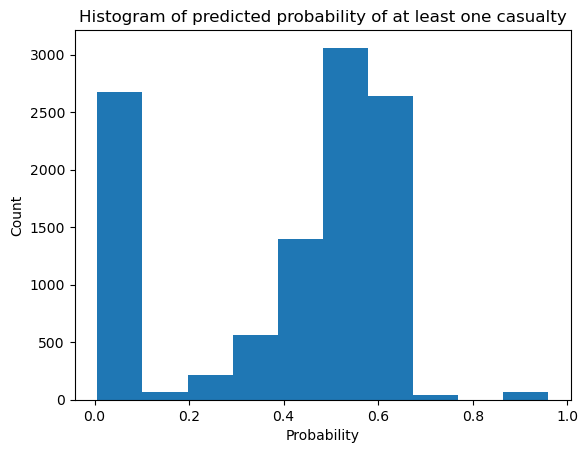

In [198]:
%matplotlib inline
fig,ax = plt.subplots()

ax.hist(df_testing['Casualty_Probability'])
ax.set_ylabel('Count')
ax.set_xlabel('Probability')
ax.set_title('Histogram of predicted probability of at least one casualty')

plt.show()

In [199]:
# Split risk categories equally
qb12 = df_testing['Casualty_Probability'].quantile(0.3333)
qb23 = df_testing['Casualty_Probability'].quantile(0.6667)
# qb34 = df_testing['Casualty_Probability'].quantile(0.6)
# qb45 = df_testing['Casualty_Probability'].quantile(0.8)

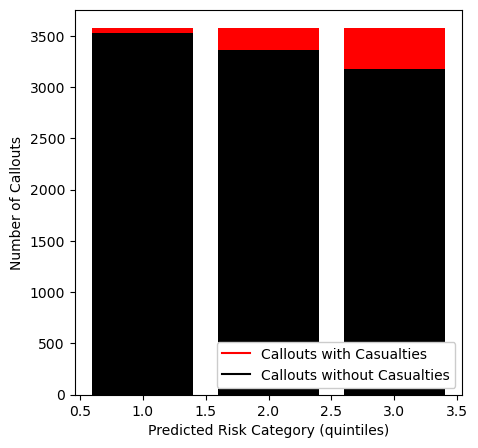

In [204]:
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot2grid((1,1),(0,0))

for q,qlb,qub in zip(np.arange(1,4,1),[0,qb12,qb23],[qb12,qb23,1]):
    ax1.bar(q,len(df_testing[(df_testing['Casualty_Count']==0)&(df_testing['Casualty_Probability']>qlb)&(df_testing['Casualty_Probability']<qub)]),color='k')
    ax1.bar(q,len(df_testing[(df_testing['Casualty_Count']==1)&(df_testing['Casualty_Probability']>qlb)&(df_testing['Casualty_Probability']<qub)]),color='r',
            bottom=len(df_testing[(df_testing['Casualty_Count']==0)&(df_testing['Casualty_Probability']>qlb)&(df_testing['Casualty_Probability']<qub)]))
    
ax1.set_ylabel('Number of Callouts')
ax1.set_xlabel('Predicted Risk Category (quintiles)')
# ax1.set_ylim([0,2250])

casualties = Line2D([],[],c='r')
no_casualties = Line2D([],[],c='k')

legend = plt.legend([casualties,no_casualties],['Callouts with Casualties','Callouts without Casualties'],loc='lower right')
legend.get_frame().set_alpha(None)

**How to link back to individual buildings?**

In [73]:
df_testing['risk_categories'] = pd.cut(df_testing['Casualty_Probability'],[0,qb12,qb23,qb34,qb45,1],labels=np.arange(1,6,1))

In [74]:
df_testing[['Casualty_Count','Casualty_Probability','risk_categories']]

,Casualty_Count,Casualty_Probability,risk_categories
6,0,0.276828,1
12,0,0.219930,1
20,0,0.572437,5
22,0,0.326938,1
25,0,0.564872,5
...,...,...,...
75616,0,0.411503,2
75627,0,0.379818,1
75629,0,0.547368,4
75631,0,0.395970,2


# Load All of New Zealand Data in

In [172]:
df_new_zealand = pd.read_csv('Buildings_AllNZ_AllColumns_SA1.csv')
df_new_zealand.rename(columns={'GNS_sa1Codes':'SA12018_V1','GNS_Outline_id':'OID_'},inplace=True)

C:\Users\shannonb\AppData\Local\miniconda3\envs\p37\lib\site-packages\IPython\core\interactiveshell.py:3457: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [173]:
df_new_zealand.rename(columns={
    "Use_Category":"GNS_Use_Category",
    "Construction_Type":"GNS_Construction_Type_1",
    "Age":"GNS_Age",
    "Storeys":"GNS_Storeys",
    "Floor_Area":"GNS_Floor_Area",
    "Site_Cover":"GNS_Site_Cover",
    "Roof_Const":"GNS_Roof_Const",
    "Wall_Const":"GNS_Wall_Const",
    "Floor_Height":"GNS_Floor_Hgt",
    "Roof_Pitch":"GNS_Roof_Pitch",
    "Parapet":"GNS_Parapet",
    "Rep_Cost":"GNS_Rep_Cost",
    "Rep_Cost_multi":"GNS_Rep_Cost_multi",
    "Units":"GNS_Num_Units",
    "Res_Units":"GNS_Res_Units",
    "NonRes_Units":"GNS_NonRes_Units",
    "Assign_type":"GNS_Assign_type",
    "Building_dist":"GNS_Building_dist",
    "Neighbour_dist":"GNS_Neighb_Dist"
},inplace=True)

In [174]:
df_new_zealand = df_new_zealand.drop(['Outline_id','Point_id','Outline_id','Point_id','x_coord','y_coord','UseCat_code','ConType_code','Roof_code','Wall_code','RoofPitch_code','Parapet_code','Assign_code'],axis=1)

In [176]:
df_dwelling1 = pd.read_csv('Census/census_dwelling1.csv')
df_dwelling2 = pd.read_csv('Census/census_dwelling2.csv')
df_household = pd.read_csv('Census/census_household.csv')
df_individual1 = pd.read_csv('Census/census_individual_1.csv')

In [177]:
df_dwelling1.rename(columns={'SA1':'sa1'},inplace=True)
df_dwelling2.rename(columns={'SA1':'sa1'},inplace=True)

In [178]:
df_individual2a = pd.read_csv('Census/census_individual_2a.csv')
df_individual2b = pd.read_csv('Census/census_individual_2b.csv')
df_individual2c = pd.read_csv('Census/census_individual_2c.csv')

In [179]:
df_individual3a = pd.read_csv('Census/census_individual_3a.csv')
df_individual3b = pd.read_csv('Census/census_individual_3b.csv')

In [180]:
df_list = [df_dwelling1, df_dwelling2, df_household, df_individual1, df_individual2a,
           df_individual2b, df_individual2c, df_individual3a, df_individual3b]

In [181]:
def merge_dataframes_on_index(df_list):
    """
    Merge a list of pandas DataFrames by joining on their index.
    
    Parameters:
    df_list (list of pandas DataFrames): List of pandas DataFrames to be merged.
    
    Returns:
    merged_df (pandas DataFrame): Merged DataFrame.
    """
    df_list = [x[~x.sa1.isna()] for x in df_list]
    df_list = [x.set_index('sa1') for x in df_list]
    
    if not df_list:
        return None
    
    # Check if all DataFrames have unique indices
    indices = [df.index.is_unique for df in df_list]
    if not all(indices):
        raise ValueError("All DataFrames must have unique indices.")
    
    # Merge DataFrames
    merged_df = pd.concat(df_list, axis=1)
    
    return(merged_df)

In [186]:
df_census_data = merge_dataframes_on_index(df_list)

In [187]:
df_census_data.rename(columns={'sa1':'sa1Codes'},inplace=True)

In [ ]:
df_new_zealand.set_index('sa1Codes',inplace=True)

In [189]:
df_new_zealand_joined = df_new_zealand.join(df_census_data)

In [192]:
df_overlap = df_new_zealand_joined[list(df_processed_data)]

KeyError: "['OID_', 'Percent_Not_Saved', 'Damage_m2', 'Casualty_Count', 'Fatality_Count', 'Injury_Count', 'GNS_Neighb_Dist', 'First_Arrival_Mins', 'Second_Arrival_Mins', 'MB2020_V2_', 'NZDep2018', 'SA12018_V1', 'smoking.e', 'Fire_Cause_Group_Name', 'Heat_Source_Group_Name', 'date_count', 'minutes'] not in index"

In [193]:
df_new_zealand_joined

,Unnamed: 0,GNS_Use_Category,GNS_Construction_Type_1,GNS_Age,GNS_Storeys,GNS_Floor_Area,GNS_Site_Cover,GNS_Roof_Const,GNS_Wall_Const,GNS_Floor_Hgt,...,hrsEmploy.30_39,hrsEmploy.40_49,hrsEmploy.50_59,hrsEmploy.60more,unpaid.household,unpaid.childHH,unpaid.illHH,unpaid.childNH,unpaid.illNH,unpaid.voluntary
7000000,38032,Mixed non-residential,Steel Braced Frame,1980.0,1.0,988.0,988.0,Steel/G-Iron,Steel/G-Iron,0.2,...,21.0,31.0,0.0,5.0,79.0,24.0,13.0,20.0,10.0,37.0
7000000,337533,Residential Dwelling,Light Timber,1980.0,1.0,60.0,60.0,Steel/G-Iron,Weatherboard,0.5,...,21.0,31.0,0.0,5.0,79.0,24.0,13.0,20.0,10.0,37.0
7000000,338884,Residential Dwelling,Light Timber,1980.0,1.0,100.0,100.0,Steel/G-Iron,Fibre Cement,0.5,...,21.0,31.0,0.0,5.0,79.0,24.0,13.0,20.0,10.0,37.0
7000000,387024,Residential Dwelling,Light Timber,1940.0,1.0,20.0,20.0,Steel/G-Iron,Fibre Cement,0.4,...,21.0,31.0,0.0,5.0,79.0,24.0,13.0,20.0,10.0,37.0
7000000,395660,Residential Dwelling,Light Timber,1980.0,1.0,90.0,90.0,Steel/G-Iron,Fibre Cement,0.5,...,21.0,31.0,0.0,5.0,79.0,24.0,13.0,20.0,10.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7029864,102375,Residential Dwelling,Light Timber,1950.0,1.0,120.0,120.0,Tile Profile,Brick,0.5,...,16.0,25.0,12.0,16.0,90.0,10.0,10.0,23.0,16.0,13.0
7029864,102492,Community,Light Timber,2010.0,1.0,0.0,0.0,Steel/G-Iron,Steel/G-Iron,0.2,...,16.0,25.0,12.0,16.0,90.0,10.0,10.0,23.0,16.0,13.0
7029864,131568,Residential Dwelling,Light Timber,2010.0,1.0,136.0,136.0,Steel/G-Iron,Brick,0.2,...,16.0,25.0,12.0,16.0,90.0,10.0,10.0,23.0,16.0,13.0
7029866,636455,"Industrial - Manufacturing, Storage",Light Timber,1970.0,1.0,70.0,70.0,Steel/G-Iron,Aluminium,0.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [191]:
df_processed_data

,OID_,Percent_Not_Saved,Damage_m2,Casualty_Count,Fatality_Count,Injury_Count,GNS_Age,GNS_Storeys,GNS_Floor_Area,GNS_Site_Cover,...,Fire_Cause_Group_Name,Heat_Source_Group_Name,GNS_Use_Category,GNS_Construction_Type_1,GNS_Roof_Const,GNS_Wall_Const,GNS_Roof_Pitch,GNS_Parapet,date_count,minutes
0,1,79,1,0,0,0,1970.0,1.0,140.0,140.0,...,Mechanical Failure or Malfunction,Electrical Equipment,Residential Dwelling,Light Timber,Steel/G-Iron,Weatherboard,GENTLE (10–25 deg),No Parapet,7304,1401
1,3,89,6,0,0,0,1910.0,1.0,90.0,90.0,...,Deliberately Lit Fire,"""Cigarettes, Matches and Candles""",Residential Dwelling,Light Timber,Steel/G-Iron,Mix.Material,GENTLE (10–25 deg),No Parapet,7304,1340
2,4,79,1,0,0,0,1910.0,1.0,90.0,90.0,...,Other or Undetermined Cause,Exposure Fire,Residential Dwelling,Light Timber,Steel/G-Iron,Mix.Material,GENTLE (10–25 deg),No Parapet,7304,1340
3,7,79,3,0,0,0,1990.0,1.0,110.0,110.0,...,Carelessness with Heat Source,"""Cigarettes, Matches and Candles""",Residential Dwelling,Light Timber,Steel/G-Iron,Fibre Cement,GENTLE (10–25 deg),No Parapet,7304,489
4,8,80,30,0,0,0,1970.0,1.0,100.0,100.0,...,Deliberately Lit Fire,Not Recorded,Residential Dwelling,Light Timber,Steel/G-Iron,Fibre Cement,MODERATE (25–40 deg),No Parapet,7304,177
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75651,111131,79,1,0,0,0,1990.0,1.0,195.0,195.0,...,Carelessness with Heat Source,"""Cigarettes, Matches and Candles""",Residential Dwelling,Light Timber,Steel/G-Iron,Stone,GENTLE (10–25 deg),No Parapet,0,365
75652,111132,79,9,0,0,0,NaN,NaN,NaN,NaN,...,Operating Failure,Outside Fire,Appurtenant,Light Timber,NaN,NaN,NaN,NaN,0,316
75653,111135,89,40,0,0,0,1970.0,1.0,101.0,101.0,...,Deliberately Lit Fire,Not Recorded,Residential Dwelling,Light Timber,Steel/G-Iron,Fibre Cement,GENTLE (10–25 deg),No Parapet,0,204
75654,111136,79,12,0,0,0,NaN,NaN,NaN,NaN,...,Deliberately Lit Fire,"""Explosives, Fire Works""","Industrial - Manufacturing, Storage",Light Industrial,NaN,NaN,NaN,NaN,0,153


In [115]:
df_individual

,sa1,X3,X17,X18,X19,X79,X90,X91,X92,X93,...,ethnicGroup.NZ,language.english,language.maori,language.samoan,language.NZsign,language.other,language.tooYoung,descent.Maori,descent.NoMaori,descent.dontKnow
0,7000000.0,141.0,75.0,66.0,141.0,48.1,24.0,30.0,69.0,21.0,...,0.0,100.0,31.0,0.0,0.0,0.0,0.0,95.0,4.0,2.0
1,7000001.0,114.0,60.0,54.0,114.0,36.5,30.0,21.0,48.0,18.0,...,0.0,100.0,28.0,2.0,0.0,2.0,2.0,84.0,15.0,0.0
2,7000002.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7000003.0,225.0,120.0,105.0,225.0,30.5,57.0,54.0,75.0,36.0,...,0.0,96.0,44.0,1.0,0.0,2.0,2.0,93.0,6.0,0.0
4,7000004.0,138.0,69.0,66.0,138.0,52.2,24.0,15.0,69.0,30.0,...,0.0,97.0,26.0,0.0,0.0,2.0,0.0,73.0,21.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29886,7999914.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29887,7999915.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29888,7999916.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
29889,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
